<a href="https://colab.research.google.com/github/sumitra288/ML-LAB-A1-G3-/blob/main/Experiment_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')


In [ ]:

data = load_breast_cancer()
X = data.data
y = data.target

print("Feature shape:", X.shape)
print("Target shape:", y.shape)
print("Feature names:", data.feature_names)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("\n Data preprocessed successfully.")


Feature shape: (569, 30)
Target shape: (569,)
Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

 Data preprocessed successfully.


In [ ]:

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)


def sigmoid_derivative(A):
    return A * (1 - A)

def relu_derivative(Z):
    return (Z > 0).astype(float)


def compute_bce_loss(Y, Y_hat):
    m = Y.shape[1]
    epsilon = 1e-15
    Y_hat = np.clip(Y_hat, epsilon, 1 - epsilon)
    return -np.sum(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat)) / m

def compute_mse_loss(Y, Y_hat):
    return np.mean((Y_hat - Y) ** 2)


In [ ]:
class MyANNClassifier:
    def __init__(self, layer_dims, learning_rate=0.01, n_iterations=1000, loss='bce'):
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.loss = loss
        self.parameters_ = {}
        self.costs_ = []
        self._initialize_parameters()

    def _initialize_parameters(self):
        np.random.seed(42)
        for l in range(1, len(self.layer_dims)):
            self.parameters_[f'W{l}'] = np.random.randn(self.layer_dims[l], self.layer_dims[l-1]) * 0.01
            self.parameters_[f'b{l}'] = np.zeros((self.layer_dims[l], 1))

    def _forward_propagation(self, X):
        A = X
        cache = []
        L = len(self.layer_dims) - 1
        for l in range(1, L):
            Z = np.dot(self.parameters_[f'W{l}'], A) + self.parameters_[f'b{l}']
            A = relu(Z)
            cache.append((A, Z))
        ZL = np.dot(self.parameters_[f'W{L}'], A) + self.parameters_[f'b{L}']
        AL = sigmoid(ZL)
        cache.append((AL, ZL))
        return AL, cache

    def _backward_propagation(self, Y, Y_hat, cache):
        grads = {}
        m = Y.shape[1]
        L = len(self.layer_dims) - 1

        if self.loss == 'bce':
            dA = -(np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
        else:
            dA = 2 * (Y_hat - Y)

        A_L, Z_L = cache[-1]
        dZ = dA * sigmoid_derivative(A_L)
        A_prev, _ = cache[-2] if len(cache) > 1 else (None, None)
        grads[f'dW{L}'] = np.dot(dZ, A_prev.T if A_prev is not None else X.T) / m
        grads[f'db{L}'] = np.sum(dZ, axis=1, keepdims=True) / m

        for l in reversed(range(1, L)):
            A, Z = cache[l-1]
            dA = np.dot(self.parameters_[f'W{l+1}'].T, dZ)
            dZ = dA * relu_derivative(Z)
            A_prev = cache[l-2][0] if l > 1 else self.X
            grads[f'dW{l}'] = np.dot(dZ, A_prev.T if l > 1 else self.X.T) / m
            grads[f'db{l}'] = np.sum(dZ, axis=1, keepdims=True) / m

        return grads

    def _update_parameters(self, grads):
        for l in range(1, len(self.layer_dims)):
            self.parameters_[f'W{l}'] -= self.learning_rate * grads[f'dW{l}']
            self.parameters_[f'b{l}'] -= self.learning_rate * grads[f'db{l}']

    def fit(self, X, y):
        self.X = X.T
        Y = y.reshape(1, -1)
        for i in range(self.n_iterations):
            Y_hat, cache = self._forward_propagation(self.X)
            loss = compute_bce_loss(Y, Y_hat) if self.loss == 'bce' else compute_mse_loss(Y, Y_hat)
            grads = self._backward_propagation(Y, Y_hat, cache)
            self._update_parameters(grads)
            if i % 500 == 0:
                print(f"Iteration {i}: Loss = {loss:.4f}")
            self.costs_.append(loss)
        print(" Training complete.")

    def predict(self, X):
        Y_hat, _ = self._forward_propagation(X.T)
        return (Y_hat > 0.5).astype(int).flatten()


In [ ]:

model1 = MyANNClassifier([30, 10, 1], learning_rate=0.001, n_iterations=5000, loss='bce')
model1.fit(X_train_scaled, y_train)
pred1 = model1.predict(X_val_scaled)
print("Model 1 (BCE):")
print(classification_report(y_val, pred1))


model2 = MyANNClassifier([30, 10, 1], learning_rate=0.001, n_iterations=5000, loss='mse')
model2.fit(X_train_scaled, y_train)
pred2 = model2.predict(X_val_scaled)
print("Model 2 (MSE):")
print(classification_report(y_val, pred2))


model3 = MyANNClassifier([30, 10, 5, 1], learning_rate=0.001, n_iterations=5000, loss='bce')
model3.fit(X_train_scaled, y_train)
pred3 = model3.predict(X_val_scaled)
print("Model 3 (Deeper):")
print(classification_report(y_val, pred3))


Iteration 0: Loss = 0.6932
Iteration 500: Loss = 0.6859
Iteration 1000: Loss = 0.6801
Iteration 1500: Loss = 0.6752
Iteration 2000: Loss = 0.6705
Iteration 2500: Loss = 0.6651
Iteration 3000: Loss = 0.6574
Iteration 3500: Loss = 0.6445
Iteration 4000: Loss = 0.6211
Iteration 4500: Loss = 0.5805
 Training complete.
Model 1 (BCE):
              precision    recall  f1-score   support

           0       1.00      0.65      0.79        63
           1       0.83      1.00      0.91       108

    accuracy                           0.87       171
   macro avg       0.92      0.83      0.85       171
weighted avg       0.89      0.87      0.86       171

Iteration 0: Loss = 0.2500
Iteration 500: Loss = 0.2481
Iteration 1000: Loss = 0.2464
Iteration 1500: Loss = 0.2449
Iteration 2000: Loss = 0.2435
Iteration 2500: Loss = 0.2422
Iteration 3000: Loss = 0.2411
Iteration 3500: Loss = 0.2399
Iteration 4000: Loss = 0.2388
Iteration 4500: Loss = 0.2375
 Training complete.
Model 2 (MSE):
           

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 500: Loss = 0.6862
Iteration 1000: Loss = 0.6807
Iteration 1500: Loss = 0.6765
Iteration 2000: Loss = 0.6732
Iteration 2500: Loss = 0.6706
Iteration 3000: Loss = 0.6686
Iteration 3500: Loss = 0.6670
Iteration 4000: Loss = 0.6658
Iteration 4500: Loss = 0.6648
 Training complete.
Model 3 (Deeper):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.63      1.00      0.77       108

    accuracy                           0.63       171
   macro avg       0.32      0.50      0.39       171
weighted avg       0.40      0.63      0.49       171



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam',
                    learning_rate_init=0.001, max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)
pred4 = mlp.predict(X_val_scaled)

print("Model 4 (sklearn MLPClassifier):")
print(classification_report(y_val, pred4))


Model 4 (sklearn MLPClassifier):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        63
           1       0.99      0.99      0.99       108

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



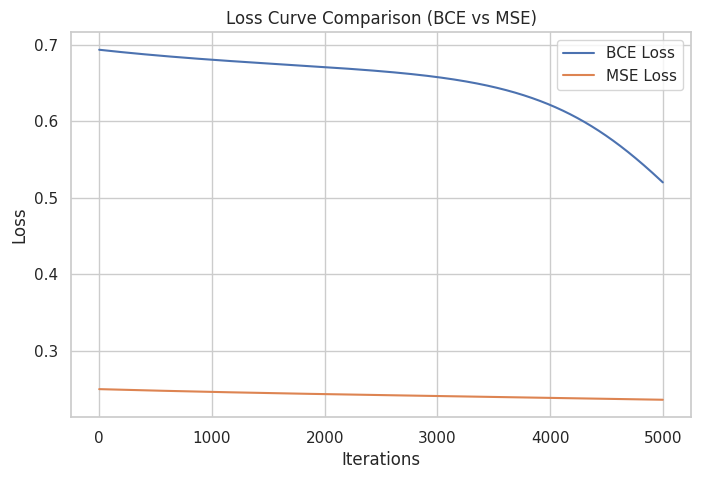

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(model1.costs_, label='BCE Loss')
plt.plot(model2.costs_, label='MSE Loss')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Curve Comparison (BCE vs MSE)")
plt.legend()
plt.show()
